**Topics to Hashtags**

**Write down what you have done**

**Try different approach for word2word **



In [ ]:
import pandas as pd
import re
from google.colab import files
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import nltk
from nltk.util import ngrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser

nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop = stopwords.words("english")

from google.colab import drive
drive.mount('/content/drive')
dataset = pd.read_json("/content/drive/My Drive/Colab Notebooks/hashtags-en-tweets.jsonl.gz", compression = "gzip", lines=True)

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
def export_hashtags():
  a = pd.Series([item for sublist in dataset.hashtags for item in sublist])
  df = a.value_counts().sort_index().rename_axis('hashtag').reset_index(name='times')
  df = df.nlargest(3000, "times")
  df = df.reset_index()
  df = df[["hashtag", "times"]]
  df.to_json("hashtags_counts.json")
  files.download("hashtags_counts.json")

Deleting Duplicates, then using the SnowballStemmer to stemm words. 
Stemming is the task of reducing a word to its stem (main part)
Credits:
https://stackoverflow.com/questions/37443138/python-stemming-with-pandas-dataframe
Removing Links: https://stackoverflow.com/questions/51994254/removing-url-from-a-column-in-pandas-dataframe
Alphanumeric: https://stackoverflow.com/questions/46241120/how-to-remove-non-alpha-numeric-characters-from-strings-within-a-dataframe-colum

In [ ]:
!pip install ekphrasis -U
!pip install gensim
import gensim
from collections import defaultdict
from gensim import corpora
import nltk
from ekphrasis.classes.segmenter import Segmenter
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases

def preprocess():
  ds = dataset[dataset["quoted_tweet_id"].isnull()]  #198954 left
  ds = ds.reset_index()
  ds = ds.head(128)
  ds = ds.drop(columns=["index", "date", "quoted_tweet_id", "user_id", "id", "reply_count","quote_count", "retweet_count", "in_reply_to_tweet_id", "like_count"])
  ds = ds.replace({"text": {"\n":" ", "ö":"oe", "ü":"ue", "ä":"ae", "ß":"ss", "Ö":"Oe", "Ä":"Ae", "Ü":"Ue"}})  
  ds["text2"] = ds["text"].apply(lambda x: " ".join(re.sub("(@[A-Za-z0-9_]+)|(#[A-Za-z0-9_]+)|([^A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))
  ds["text2"] = ds["text2"].apply(lambda x: " ".join([word for word in x.split() if word not in (stop)]))
  ds["text2"] = ds["text2"].apply(lambda x: " ".join([word.lower() for word in x.split()]))
  ds["text3"] = ds["text2"]


  from ekphrasis.classes.preprocessor import TextPreProcessor
  from ekphrasis.classes.tokenizer import SocialTokenizer
  from ekphrasis.dicts.emoticons import emoticons

  text_processor = TextPreProcessor(
      normalize=[],
      # terms that will be annotated
      annotate={},
      fix_html=False,  # fix HTML tokens
      
      # corpus from which the word statistics are going to be used for word segmentation 
      segmenter="twitter", 
      
      # corpus from which the word statistics are going to be used for spell correction
      corrector="twitter", 
      
      unpack_hashtags=False,  # perform word segmentation on hashtags
      unpack_contractions=True,  # Unpack contractions (can't -> can not)
      spell_correct_elong=False,  # spell correction for elongated words
      
      # select a tokenizer. You can use SocialTokenizer, or pass your own
      # the tokenizer, should take as input a string and return a list of tokens
      tokenizer=SocialTokenizer(lowercase=True).tokenize,
      
      # list of dictionaries, for replacing tokens extracted from the text,
      # with other expressions. You can pass more than one dictionaries.
      #dicts=[emoticons]
  )

  ds["text3"] = ds["text3"].apply(lambda x: " ".join(text_processor.pre_process_doc(x)))

  # segmenter using the word statistics from Twitter
  seg_tw = Segmenter(corpus="twitter")

  ds["text3"] = ds["text3"].apply(lambda x: " ".join([seg_tw.segment(word) for word in x.split()]))

  nltk.download('omw-1.4')
  #Tokenize and remove single letters
  ds["gensimtext"] = ds["text3"].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))

  #Lemmatize
  lemmatizer = WordNetLemmatizer()
  ds["gensimtext"] = ds["gensimtext"].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

  ds = ds.drop(columns=["text", "text2", "text3"])

  #Compute bigrams

  return ds

ds = preprocess()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading twitter - 1grams ...
Reading twitter - 1grams ...
Reading twitter - 2grams ...


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Adjacency Matrix for Word to Word
I used the direct neighboring words. If a word is at the beginning or end of a Sentence it only has one neighbor, else 2.
Try to do Bag of Words like Hashtag

In [ ]:
!pip install transformers
import torch
from transformers import BertTokenizer, BertModel

#ds = ds.head(100)

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
input_ids_h = []
attention_masks_h = []

# For every sentence...
for i in ds.index:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    sent = ds["gensimtext"][i]
    hash = ds["hashtags"][i]
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 32,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

    encoded_dict_h = tokenizer.encode_plus(
                        hash,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 16,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    input_ids_h.append(encoded_dict_h['input_ids'])
    attention_masks_h.append(encoded_dict_h['attention_mask'])

# Convert the lists into tensors.
tokens_tensor = torch.cat(input_ids, dim=0)
segments_tensors = torch.cat(attention_masks, dim=0)

tokens_tensor_h = torch.cat(input_ids_h, dim=0)
segments_tensors_h = torch.cat(attention_masks_h, dim=0)


# Print sentence 0, now as a list of IDs.
print('Original: ', ds["gensimtext"][0])
print('Token IDs:', tokens_tensor[0])
print('Original: ', ds["hashtags"][0])
print('Token IDs:', tokens_tensor_h[0])


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Loading BERT tokenizer...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  training pic team final session ap piano setting
Token IDs: tensor([  101,  2731, 27263,  2136,  2345,  5219,  9706,  3682,  4292,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
Original:  ['LiverpoolInter', 'ForzaInter', 'UCL']
Token IDs: tensor([101, 100, 100, 100, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Load pre-trained model (weights)
#ds = ds.head(20)
model = BertModel.from_pretrained('bert-base-uncased',
                                 output_hidden_states = False, # Whether the model returns all hidden-states.
                                 )

from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:

import torch
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
from sklearn.decomposition import PCA

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Set the batch size.  
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(tokens_tensor, segments_tensors)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

prediction_data = TensorDataset(tokens_tensor_h, segments_tensors_h)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader_h = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Tracking variables 
predictions, predictions_h = [], []

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

# Predict 
def predict(dataloader, predictions):
  pca = PCA(n_components=16)
  for batch in dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)
        #hidden_states = outputs[2]
    principalComponents = []
    print(len(outputs), len(outputs[0]), len(outputs[0][0]),  len(outputs[0][0][0]))
    for i in range(0, len(outputs[0])):
      principalComponents.append(pca.fit_transform(outputs[0][i]))

    logits = torch.tensor(principalComponents)
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    #hidden_states = hidden_states.detach().cpu().numpy()
    
    # Store predictions and true labels
    predictions.append(torch.tensor(logits))
    #predictions.append(hidden_states)
    
  return predictions

predictions = predict(prediction_dataloader, predictions)
predictions_h = predict(prediction_dataloader_h, predictions_h)

print('    DONE.')


No GPU available, using the CPU instead.
2 16 32 768
2 16 32 768
2 16 32 768
2 16 32 768
2 16 32 768
2 16 32 768
2 16 32 768
2 16 32 768
2 16 16 768
2 16 16 768
2 16 16 768
2 16 16 768
2 16 16 768
2 16 16 768
2 16 16 768
2 16 16 768
    DONE.


In [ ]:
print(type(predictions_h))
print(len(predictions_h))
print(type(predictions_h[0]))
print(len(predictions_h[0]))
print(len(predictions_h[0][0]))
print(len(predictions_h[0][0][0]))
#print(len(predictions[0][0][0][0]))

<class 'list'>
8
<class 'torch.Tensor'>
16
16
16


In [ ]:
token_embeddings = torch.stack(predictions, dim=0)
predictions = 0
token_embeddings_h = torch.stack(predictions_h, dim=0)
predictions_h = 0
token_vecs_sum = token_embeddings.reshape(-1, 32, 16)
token_embeddings = 0
token_vecs_sum_h = token_embeddings_h.reshape(-1, 16, 16)
token_embeddings_h = 0

In [ ]:
print(type(token_vecs_sum_h))
print(len(token_vecs_sum_h))
print(type(token_vecs_sum_h[0]))
print(len(token_vecs_sum_h[0]))
print(len(token_vecs_sum_h[0][0]))

# `hidden_states` has shape [13 x 1 x 22 x 768]
sentence_embedding = []
# `token_vecs` is a tensor with shape [22 x 768]
for i in range(0, len(token_vecs_sum)):
  token_vecs = token_vecs_sum[i]
  #print(len(token_vecs), len(token_vecs[i]))
# Calculate the average of all 22 token vectors.
  sentence = torch.mean(token_vecs, dim=0)
  #print(sentence)
  sentence_embedding.append(sentence)

print ('Shape is: %d x %d' % (len(sentence_embedding), len(sentence_embedding[0])))

<class 'torch.Tensor'>
128
<class 'torch.Tensor'>
16
16
Shape is: 128 x 16


# Word - Word Matrix

In [ ]:
import math
ds.tokens = [sent.split() for sent in ds.gensimtext]

res = []
wordconversion = {}
i = 0
for sent in ds.tokens:
  for x in sent:
    if x not in wordconversion:
        value = wordconversion[x] = i
        i += 1
    else:
        value = wordconversion[x]
    res.append(value)
#print(wordconversion[0])
worddict = {}
words = {}
wwsum = 0

for isent in range(0, len(ds.tokens)):
  sent = ds.tokens[isent]
  for i in range(0,len(sent)):
    word = wordconversion[sent[i]]
    if worddict.get(word) == None:
        worddict[word] = {}
    if i -1 >= 0:
      left = wordconversion[sent[i - 1]]
      wwsum += 1
      if worddict[word].get(left) == None:
        worddict[word][left] = 1   
      else:
        worddict[word][left] += 1

    if i + 1 < len(sent):
      right = wordconversion[sent[i + 1]]
      wwsum += 1
      if worddict[word].get(right) == None:
        worddict[word][right] = 1
      else: 
        worddict[word][right] +=1

factor_w_w = {}
for key in worddict:
  for k in worddict[key]:
    if factor_w_w.get(key) == None:
      factor_w_w[key] = {}
    #factor_w_w[key][k] = math.log(worddict[key][k] * wwsum / sum(worddict[key].values()) / sum(worddict[k].values()))
    factor_w_w[key][k] = worddict[key][k] / wwsum
print(worddict[1])
print(factor_w_w[1])

{0: 1, 2: 1}
{0: 0.0005592841163310962, 2: 0.0005592841163310962}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


#Hashtag - Hashtag

In [ ]:
hashdict = {}

res = []
hashconversion = {}
i = 0
for sent in ds.hashtags:
  for x in sent:
    if x not in hashconversion:
        value = hashconversion[x] = i
        i += 1
    else:
        value = hashconversion[x]
    res.append(value)
hhsum = 0

for sent in ds.hashtags:
  for i in range(0,len(sent)):
    hash = hashconversion[sent[i]]
    
    if hashdict.get(hash) == None:
        hashdict[hash] = {}
    for j in range(0, len(sent)):
      #hhsum += 1
      left = hashconversion[sent[j]]
      if hashdict[hash].get(left) == None and left != hash:
        hashdict[hash][left] = 1
        hhsum += 1
      elif left != hash:
        hashdict[hash][left] += 1
        hhsum += 1
        

factor_h_h = {}

for key in hashdict:
  for k in hashdict[key]:
    if factor_h_h.get(key) == None:
      factor_h_h[key] = {}
    #factor_h_h[key][k] = math.log(hashdict[key][k] * wwsum / sum(hashdict[key].values()) * sum(hashdict[k].values()))
    factor_h_h[key][k] = hashdict[key][k] / hhsum

#writematrix("M_h_h.txt", hashdict, factor_h_h, len(hashdict), len(hashdict))


# Hashtag - Tweet

In [ ]:
hashtweetdict = {}
htsum = 0

for i in ds.index:
  for j in range(0,len(ds.hashtags[i])):
    hash = hashconversion[ds.hashtags[i][j]]
    if hashtweetdict.get(hash) == None:
      hashtweetdict[hash] = {}
    htsum += 1
    hashtweetdict[hash][j] = 1

factor_h_t = {}

for key in hashtweetdict:
  for k in hashtweetdict[key]:
    if factor_h_t.get(key) == None:
      factor_h_t[key] = {}
    factor_h_t[key][k] = hashtweetdict[key][k] / htsum

#writematrix("M_h_t.txt", hashtweetdict, factor_h_t, len(hashtweetdict), len(ds.index))

# Tweet - Word

In [ ]:
tweetworddict = {}
twsum = 0

for i in ds.index:
  tweetworddict[i] = {}
  for j in range(0,len(ds.tokens[i])):
    word = wordconversion[ds.tokens[i][j]]
    if tweetworddict[i].get(word) == None:
      tweetworddict[i][word] = 1
    else:
      tweetworddict[i][word] += 1
    twsum += 1

factor_t_w = {}

for key in tweetworddict:
  for k in tweetworddict[key]:
    if factor_t_w.get(key) == None:
      factor_t_w[key] = {}
    factor_t_w[key][k] = tweetworddict[key][k] / twsum

#writematrix("M_t_w.txt", tweetworddict, factor_t_w, len(tweetworddict), len(worddict))

#Tweet Topic and Index


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
tweet_choice = [0, 1, 2, 8, 9, 10, 11, 19, 20, 21]
tweet_topics = [1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2]
tweet_chosen_topics = [tweet_topics[x] for x in tweet_choice]
#tweet_topics[0:3] + tweet_topics[8:12] + tweet_topics[19:22]

def writeindexandlabel(name, chosen, choice):
  with open('/content/drive/My Drive/Colab Notebooks/' + name + '_label.txt', 'w') as writefile:
    writefile.write(str(len(chosen)) + "\n")
    for i in chosen:
      writefile.write(str(i) + "\n")

  with open('/content/drive/My Drive/Colab Notebooks/' + name + '_index.txt', 'w') as writefile:
    writefile.write(str(len(chosen)) + "\n")
    for i in choice:
      writefile.write(str(i) + "\n")

writeindexandlabel("tweet", tweet_chosen_topics, tweet_choice)

# Hashtag Topic and Index

In [ ]:
hash_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/top_hashtags_all_new.csv", sep = ";", names = ["hashtag", "category", "category2", 1, 2, 3, 4, 5, 6, 7, 8], header = None)
hash_csv = hash_csv.drop([1, 2, 3, 4, 5, 6, 7, 8], axis=1)
hash_csv.hashtag = hash_csv.hashtag.apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))
import collections
found_hashtags = {}
found2_hashtags = {}
topics_hashtags = {}
topics2_hashtags = {}
j = 1
k = 1
for i in hash_csv.index:
  if topics_hashtags.get(hash_csv.category[i]) == None:
    topics_hashtags[hash_csv.category[i]] = j
    j += 1
  if topics2_hashtags.get(hash_csv.category2[i]) == None:
    topics2_hashtags[hash_csv.category2[i]] = k
    k += 1
  if hashconversion.get(hash_csv.hashtag[i]) != None:
    found_hashtags[hashconversion[hash_csv.hashtag[i]]] = topics_hashtags.get(hash_csv.category[i])
    found2_hashtags[hashconversion[hash_csv.hashtag[i]]] = topics2_hashtags.get(hash_csv.category2[i])

found_hashtags = collections.OrderedDict(sorted(found_hashtags.items()))

writeindexandlabel("hashtag", found_hashtags.values(), found_hashtags.keys())
writeindexandlabel("hashtag2", found2_hashtags.values(), found2_hashtags.keys())

In [ ]:
print(topics_hashtags)
print(topics_hashtags["ukraine"])

{'ukraine': 1, 'music_and_art': 2, 'environment': 3, 'internet': 4, 'america': 5, 'celebrity': 6, 'tv_program': 7, 'england': 8, 'sport': 9, 'politician': 10, 'society': 11, 'entertainment': 12, 'games': 13, 'news_outlets': 14, 'science_and_technology': 15, 'europe': 16, 'nature': 17, 'middle_east': 18, 'australia': 19, 'festival': 20, 'education': 21, 'pandemic': 22, 'russia': 23, 'military': 24, 'film': 25, 'energy': 26, 'life': 27, 'crime': 28, 'health': 29, 'travel': 30, 'work': 31, 'law': 32, 'asia': 33, 'china': 34, 'commerce': 35, 'charity': 36, 'unknown': 37, 'economy': 38, 'migration': 39, 'awards_competition': 40, 'politics': 41, 'climate': 42, 'sci_tech': 43, 'news': 44, 'gaming': 45, 'sports': 46, 'football': 47, 'tv_cinema': 48, 'music_radio': 49, 'local_news': 50, 'finance_work': 51, 'covid': 52, 'religion': 53, 'lifestyle': 54, 'tv': 55, 'awards': 56, 'music': 57}
1


[hastag1, hashtag2, hashtag3, hashtag4]
Understand Equation
Implement BERT embedding
Look into where final hashtag embedding and save it



# Include Bert embeddings
## Tweet 2 Word

In [ ]:
import math
from scipy.spatial.distance import cosine

def bertembedding(tweetind, wordind, wordind2, mode):
  if mode == "tw":
    d = 1/(1 + math.exp(- cosine(sentence_embedding[tweetind], token_vecs_sum[tweetind][wordind])))
  elif mode == "ww":
    d = 1/(1 + math.exp(- cosine(token_vecs_sum[tweetind][wordind], token_vecs_sum[tweetind][wordind2])))
  elif mode == "ht":
    d = 1/(1 + math.exp(- cosine(token_vecs_sum_h[tweetind][wordind], sentence_embedding[tweetind])))
  elif mode == "hh":
    d = 1/(1 + math.exp(- cosine(token_vecs_sum_h[tweetind][wordind], token_vecs_sum_h[tweetind][wordind2])))

  return d

tweetworddictbert = {}
for i in ds.index:
  tweetworddictbert[i] = {}
  for j in range(0,len(ds.tokens[i])):
    word = wordconversion[ds.tokens[i][j]]
    if tweetworddictbert[i].get(word) == None:
      tweetworddictbert[i][word] = bertembedding(i, j, 0,"tw") / tweetworddict[i][word]
    else:
      tweetworddictbert[i][word] = tweetworddictbert[i][word] + (bertembedding(i, j, 0, "tw") / tweetworddict[i][word])

wordworddictbert = {}
for i in ds.index:
  for j in range(0,len(ds.tokens[i])):
    word = wordconversion[ds.tokens[i][j]]
    if wordworddictbert.get(word) == None:
      wordworddictbert[word] = {}
    if j -1 >= 0:
      left = wordconversion[ds.tokens[i][j - 1]]
      if wordworddictbert[word].get(left) == None:
        wordworddictbert[word][left] = bertembedding(i, j, j-1, "ww") / worddict[word][left]
      else:
        wordworddictbert[word][left] = wordworddictbert[word][left] + (bertembedding(i, j, j-1, "ww") / worddict[word][left])
    if j + 1 < len(ds.tokens[i]):
      right = wordconversion[ds.tokens[i][j + 1]]
      if wordworddictbert[word].get(right) == None:
        wordworddictbert[word][right] = bertembedding(i, j, j+1, "ww") / worddict[word][right]
      else:
        wordworddictbert[word][right] = wordworddictbert[word][right] + (bertembedding(i, j, j+1, "ww") / worddict[word][right])

hashtweetdictbert = {}
for i in ds.index:
  for j in range(0,len(ds.hashtags[i])):
    hash = hashconversion[ds.hashtags[i][j]]
    if hashtweetdictbert.get(hash) == None:
      hashtweetdictbert[hash] = {}
    #htsum += 1
    hashtweetdictbert[hash][j] = bertembedding(i, j, 0, "ht")

hashhashdictbert = {}
for k in ds.index:
  sent = ds.hashtags[k]
  for i in range(0,len(sent)):
    hash = hashconversion[sent[i]]
    if hashhashdictbert.get(hash) == None:
        hashhashdictbert[hash] = {}
    for j in range(0, len(sent)):
      left = hashconversion[sent[j]]
      if hashhashdictbert[hash].get(left) == None and left != hash:
        hashhashdictbert[hash][left] = bertembedding(k, i, j, "hh") / hashdict[hash][left]
      elif left != hash:
        hashhashdictbert[hash][left] = hashhashdictbert[hash][left] + (bertembedding(k, i, j, "hh") / hashdict[hash][left])

In [ ]:
from scipy.spatial import distance

def writematrix(name, dictina, factor, a, b, bert):
  with open('/content/drive/My Drive/Colab Notebooks/' + name, 'w') as writefile:
    writefile.write(str(a) + " " + str(b) + "\n")
    index = sorted(dictina)
    for key in index:
      line = str(key) + " " + str(len(dictina[key]))
      index2 = sorted(dictina[key])
      for keykey in index2:
        line += " " + str(keykey) + ":" + str(distance.euclidean(factor[key][keykey], - bert[key][keykey]))
      writefile.write(line + "\n")

def writematrixbert(name, dictina, factor, a, b, bert):
  with open('/content/drive/My Drive/Colab Notebooks/' + name, 'w') as writefile:
    writefile.write(str(a) + " " + str(b) + "\n")
    index = sorted(dictina)
    for key in index:
      line = str(key) + " " + str(len(dictina[key]))
      index2 = sorted(dictina[key])
      for keykey in index2:
        line += " " + str(keykey) + ":" + str(bert[key][keykey])
      writefile.write(line + "\n")

writematrixbert("M_t_w.txt", tweetworddict, factor_t_w, len(tweetworddict), len(worddict), tweetworddictbert)
writematrixbert("M_w_w.txt", worddict, factor_w_w, len(worddict), len(worddict), wordworddictbert)
writematrixbert("M_h_t.txt", hashtweetdict, factor_h_t, len(hashtweetdict), len(ds.index), hashtweetdictbert)
writematrixbert("M_h_h.txt", hashdict, factor_h_h, len(hashdict), len(hashdict), hashhashdictbert)

In [ ]:
print(found_hashtags)
print(topics_hashtags)
arr = found_hashtags.keys()
print(list(arr))


OrderedDict([(0, 47), (2, 47), (3, 9), (4, 9), (5, 47), (7, 11), (8, 14), (10, 18), (12, 18), (14, 1), (16, 41), (17, 1), (18, 23), (19, 23), (20, 10), (21, 1), (22, 1), (23, 11), (25, 11), (26, 1), (29, 1), (32, 1), (35, 1), (37, 1), (39, 1), (40, 1), (41, 39), (42, 41), (46, 23), (47, 1), (49, 1), (50, 3), (51, 3), (52, 11), (54, 14), (57, 55), (62, 47), (65, 44), (69, 11), (70, 18), (71, 21), (74, 27), (76, 17), (77, 17), (90, 44), (91, 9), (95, 12), (96, 11), (99, 52), (102, 44), (105, 44), (107, 20), (109, 11), (112, 42), (119, 29), (124, 43), (128, 55), (129, 44), (134, 11), (137, 16), (138, 11), (141, 30), (144, 57), (149, 31), (152, 11), (153, 43), (157, 44), (165, 54), (168, 46), (169, 44), (170, 25), (171, 52), (172, 49), (173, 37), (174, 55), (177, 48), (179, 43), (180, 41), (186, 15), (187, 44), (189, 29), (192, 44), (195, 48), (196, 48), (197, 48), (200, 16), (203, 48), (205, 48), (211, 48), (212, 48), (213, 25), (215, 48), (216, 11), (217, 8), (218, 6), (224, 11), (227, 7

# Now import data from Hastag2Vec

[0.80148268 0.13543124]
[0.93990416 0.05033824]


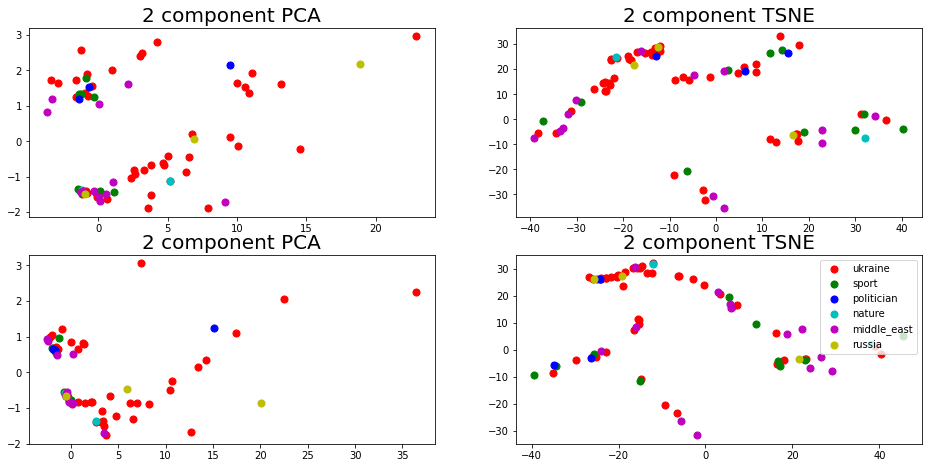

'\nlegend1 = ax.legend(*scatter.legend_elements(),\n                    loc="lower left", title="Classes")\nax.add_artist(legend1)\n'

In [ ]:
dat = pd.read_csv("/content/drive/My Drive/Colab Notebooks/W_h_5_5.txt", sep=" ", header=None)
dat2 = pd.read_csv("/content/drive/My Drive/Colab Notebooks/W_h_10_5.txt", sep=" ", header=None)

chosen = []

for i in range(0, len(dat.columns)):
  if found_hashtags.get(i) == None:
    chosen.append(len(topics_hashtags) + 1)
  else:
    chosen.append(found_hashtags.get(i))

annotations = list(range(0, 50))

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def prep_data_pca(data):
  global chosen
  for column in data:
    data[column] = data[column].apply(lambda x: float(x))
  
  data = data.transpose()
  data[16] = chosen
  

  features = list(range(0, 16))
  # Separating out the features
  x = data.loc[:, features].values
  # Separating out the target
  y = data.loc[:,[16]].values
  # Standardizing the features
  x = StandardScaler().fit_transform(x)


  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(x)
  principalDf = pd.DataFrame(data = principalComponents, columns = [1, 2])
  finalDf = pd.concat([principalDf, data[[16]]], axis = 1)
  print(pca.explained_variance_ratio_)
  return finalDf

from sklearn.manifold import TSNE

def prep_data_tsne(data):
  global chosen
  data = data.transpose()
  tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(data)
  
  x = pd.DataFrame(data = tsne, columns = [1, 2])
  x[16] = pd.DataFrame(chosen)
  finalDf = pd.concat([x, x[16]], axis = 1)
  return x

import matplotlib.pyplot as plt
def create_subplot(fig, data):
  global targets, colors, annotations
  for i in range(0, len(data)):
    ax = fig.add_subplot(len(data), 2, i + 1)
    if i%2==0:
      ax.set_title('2 component PCA', fontsize = 20)
    else:
      ax.set_title('2 component TSNE', fontsize = 20)
    for target, color in zip(targets, colors):
        indicesToKeep = data[i][16] == target
        ax.scatter(data[i].loc[indicesToKeep, 1]
                  , data[i].loc[indicesToKeep, 2]
                  , c = color
                  #, cmap = "tab20c"
                  , s = 50) 
    #for j, label in enumerate(annotations):
      #plt.annotate(label, (data[i][1][j], data[i][2][j]))
  return fig

data = prep_data_pca(dat)
data2 = prep_data_pca(dat2)
data_tsne = prep_data_tsne(dat)
data2_tsne = prep_data_tsne(dat2)
fig = plt.figure(figsize = (16,16))
#targets = list(range(1, 5))
targets = [1, 9, 10, 17, 18, 23]
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'limegreen', 'grey', 'darkorange', 'fuchsia', 'khaki']

fig = create_subplot(fig, [data, data_tsne, data2, data2_tsne])

    
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]

target_names = []
for i in targets:
  a = get_keys_from_value(topics_hashtags, i)
  a = ' '.join(a)
  target_names.append(a)

#print(target_names)
#ax.legend(target_names)
#ax.grid()

plt.legend(target_names)
plt.show()
'''
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(x)
print(X_embedded)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c = chosen[:], alpha = 0.75, s=100, cmap = "tab20c")
'''
# produce a legend with the unique colors from the scatter
'''
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
'''
#plt.legend()
#plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_mutual_info_score
import numpy as np

def eval_sil(data, labels):
  return metrics.silhouette_score(data, labels, metric='euclidean')

def eval_ami(labels_pred, labels_true):
  return adjusted_mutual_info_score(labels_pred, labels_true)

def eval(data, start, end):
  sil = []
  ami = []
  for i in range(start, end):
    kmeans_model = KMeans(n_clusters=i, random_state=1).fit(data[[1, 2]])
    labels = kmeans_model.labels_
    sil.append(eval_sil(data[[1, 2]], labels))
    ami.append(eval_ami(data[16], labels))
  frame = [sil, ami, list(range(start, end))]
  frame = np.array(frame).transpose()
  ret = pd.DataFrame(frame, columns = ["sil", "ami","cluster"])
  return ret

x = eval(data, 2, 25)
print(x)

         sil       ami  cluster
0   0.647910  0.059554      2.0
1   0.544558  0.061020      3.0
2   0.594256  0.059474      4.0
3   0.592952  0.062966      5.0
4   0.632832  0.056795      6.0
5   0.652296  0.056763      7.0
6   0.652205  0.058310      8.0
7   0.634482  0.055431      9.0
8   0.638637  0.058953     10.0
9   0.642159  0.063337     11.0
10  0.606574  0.057606     12.0
11  0.624429  0.051095     13.0
12  0.605840  0.055863     14.0
13  0.581073  0.050904     15.0
14  0.570206  0.056119     16.0
15  0.579412  0.059027     17.0
16  0.577193  0.061841     18.0
17  0.578315  0.060912     19.0
18  0.552699  0.058849     20.0
19  0.566637  0.060059     21.0
20  0.535467  0.054817     22.0
21  0.547735  0.055311     23.0
22  0.550218  0.057140     24.0


Add labels 
maybe 3D Space - Do until certain Variance value. 
Try without BERT and compare
Make visualization customizable

plotly - instead of matplotlib - maybe easier?

Evaluate with AMI, Siloutte
Merge Cluster, but add new levels